In [ ]:
%matplotlib inline

In [ ]:
pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/



# Speech Recognition with Wav2Vec2



## Overview

The process of speech recognition looks like the following.

1. Extract the acoustic features from audio waveform

2. Estimate the class of the acoustic features frame-by-frame

3. Generate hypothesis from the sequence of the class probabilities






## Preparation






In [ ]:
import os
import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

1.12.1+cu113
0.12.1+cu113
cuda


In [ ]:
SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

## Creating a pipeline

First, we will create a Wav2Vec2 model that performs the feature
extraction and the classification.

There are two types of Wav2Vec2 pre-trained weights available in
torchaudio. The ones fine-tuned for ASR task, and the ones not
fine-tuned.

Wav2Vec2 (and HuBERT) models are trained in self-supervised manner. They
are firstly trained with audio only for representation learning, then
fine-tuned for a specific task with additional labels.

The pre-trained weights without fine-tuning can be fine-tuned
for other downstream tasks as well, but this tutorial does not
cover that.

We will use :py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H` here.

There are multiple models available as
:py:mod:`torchaudio.pipelines`. Please check the documentation for
the detail of how they are trained.

The bundle object provides the interface to instantiate model and other
information. Sampling rate and the class labels are found as follow.




In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


Model can be constructed as following. This process will automatically
fetch the pre-trained weights and load it into the model.




In [ ]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


## Loading data

We will use the speech data from [VOiCES
dataset](https://iqtlabs.github.io/voices/)_, which is licensed under
Creative Commons BY 4.0.




In [ ]:
IPython.display.Audio(SPEECH_FILE)

In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

## Extracting acoustic features






In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

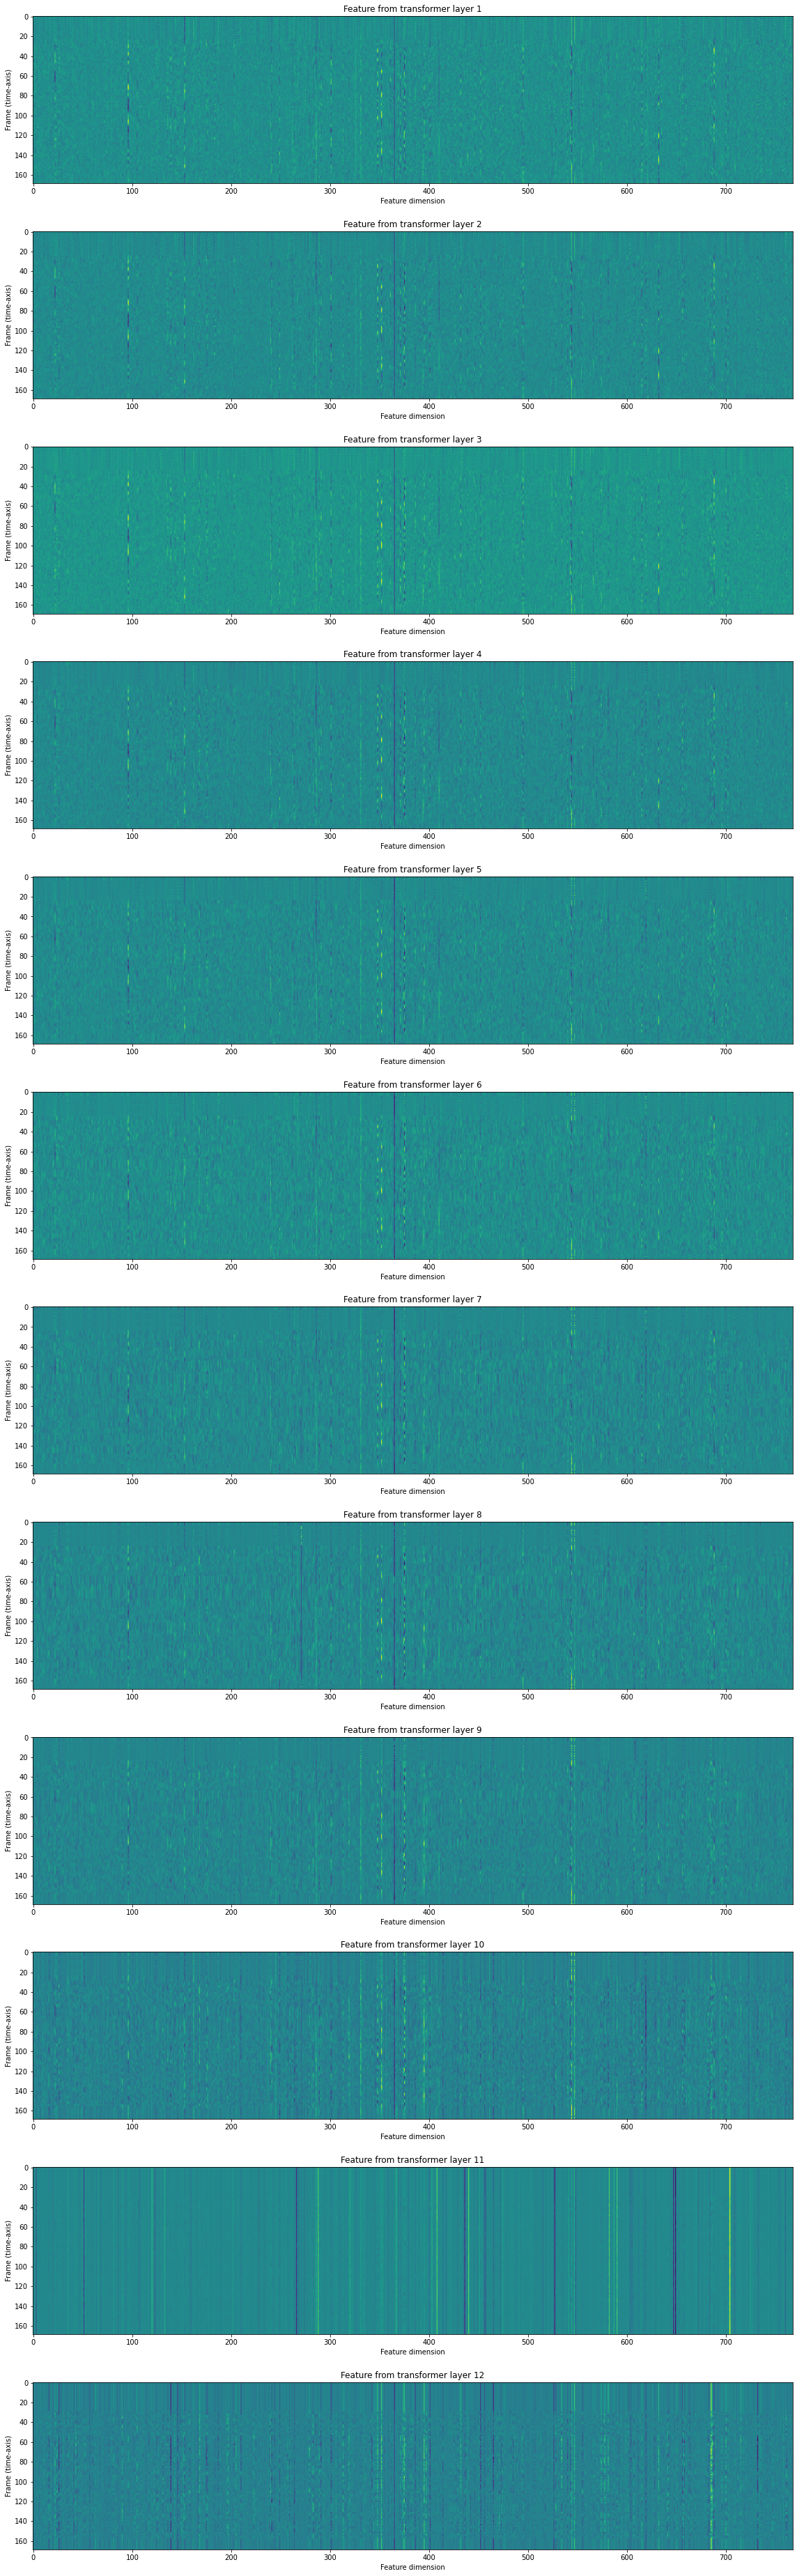

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

## Feature classification






In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

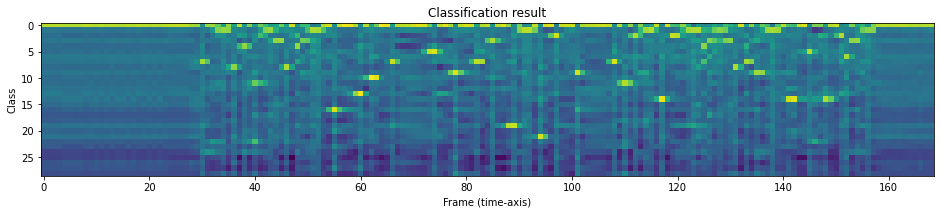

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

## Generating transcripts






In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [ ]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|
